# Correlation between objective function and performance measures

This notebook contains the code/calculations for the correlation plots used in the report

In [80]:
import wandb
import pandas as pd 
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("gustavhartz/cuad_training_gen2_v1")
summary_list = [] 
config_list = [] 
name_list = []
history_list = []
history_raw = []
for run in runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)

    # Own code
    run_df = run.history()
    # Remove logging entries where not from the validation loop
    raw_df = run_df[run_df['performance_AUPR_valid_prec_at_80_recall'].notna()]
    history_raw.append(raw_df)
    # only keep the columns we want
    df_clean = raw_df[['epoch_valid_loss','performance_AUPR_valid_aupr','performance_stats_valid_HasAns_f1','performance_stats_valid_NoAns_f1','performance_stats_valid_exact','performance_stats_valid_f1', 'performance_AUPR_valid_prec_at_80_recall']]       
    df_clean.rename(columns={'epoch_valid_loss':'Validation loss', 'performance_AUPR_valid_aupr':'AUPR', 'performance_stats_valid_HasAns_f1':'Has Ans F1', 'performance_stats_valid_NoAns_f1': 'No Ans F1', 'performance_stats_valid_exact':'EM', 'performance_stats_valid_f1':'F1', 'performance_AUPR_valid_prec_at_80_recall': 'Prec @ 80%'}, inplace=True)

    history_list.append(df_clean)


summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

df_hist = pd.concat(history_list)
df_hist_raw = pd.concat(history_raw)

/var/folders/nt/g2ndh3nx4dj16m34wq3h41lh0000gn/T/ipykernel_61518/1079354564.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nt/g2ndh3nx4dj16m34wq3h41lh0000gn/T/ipykernel_61518/1079354564.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nt/g2ndh3nx4dj16m34wq3h41lh0000gn/T/ipykernel_61518/1079354564.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We now have all the data an can make the correlation analysis

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
df_hist

,Validation loss,AUPR,Has Ans F1,No Ans F1,EM,F1,Prec @ 80%
8,0.253849,0.195557,61.106361,64.431587,58.440937,63.442448,0.000000
19,0.189731,0.316015,79.131866,58.883595,60.951698,64.906754,0.187983
31,0.173090,0.355474,80.112267,67.903336,67.288376,71.535072,0.201310
42,0.156002,0.390941,80.742455,65.997276,65.997131,70.383453,0.214929
52,0.194590,0.351730,81.778694,64.193329,64.945000,69.424370,0.225745
...,...,...,...,...,...,...,...
109,0.114053,0.438255,82.097160,74.098022,72.644669,76.477493,0.351815
119,0.140842,0.422006,82.738136,70.830498,70.444763,74.372604,0.342345
130,0.106102,0.442397,82.181572,75.493530,73.505501,77.482994,0.390485
142,0.121433,0.451765,82.075302,75.561607,73.577232,77.499207,0.400909


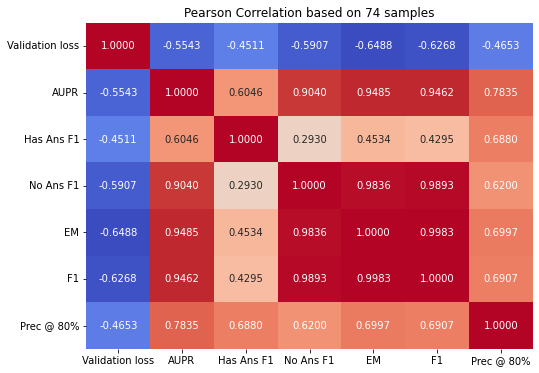

In [83]:
corr = df_hist.corr(method='pearson')


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_title(f'Pearson Correlation based on {len(df_hist)} samples')
plt.savefig('Figures_For_Report/PearsonCorrObjectiveFunction.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

In [84]:
corr**2

,Validation loss,AUPR,Has Ans F1,No Ans F1,EM,F1,Prec @ 80%
Validation loss,1.000000,0.307232,0.203465,0.348871,0.420881,0.392847,0.216498
AUPR,0.307232,1.000000,0.365513,0.817171,0.899601,0.895219,0.613865
Has Ans F1,0.203465,0.365513,1.000000,0.085877,0.205598,0.184477,0.473397
No Ans F1,0.348871,0.817171,0.085877,1.000000,0.967552,0.978681,0.384383
EM,0.420881,0.899601,0.205598,0.967552,1.000000,0.996653,0.489647
F1,0.392847,0.895219,0.184477,0.978681,0.996653,1.000000,0.477025
Prec @ 80%,0.216498,0.613865,0.473397,0.384383,0.489647,0.477025,1.000000


The Pearson’s Correlation Coefficient depicted in the plot, is a measure of linear correlation between two variables and is calculated as the relationship between the covariance of the variables and product of standard deviations of the samples. From the plot there is a clear linear correlation between the validation loss and the evaluation metrics, so the objective function seems to embed useful knowledge into the model. This is also supported by the metrics from training $REF$, when the model is improving as the validation loss decreases. The correlation coefficient looks as expected with an negative sign, due to us wanting the goal being maximizing the evaluation metrics by minimizing the validation loss. Extracting the r^2 values from the plot also reveal that there still is a lot of variance that cannot be explained by the correlation model.

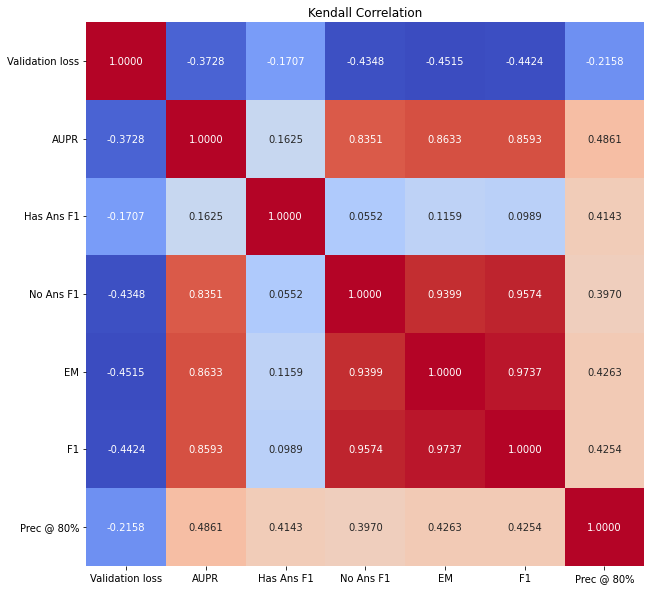

In [85]:
corr = df_hist.corr(method='kendall')


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_title('Kendall Correlation')
plt.savefig('Figures_For_Report/KendallCorrObjectiveFunction.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

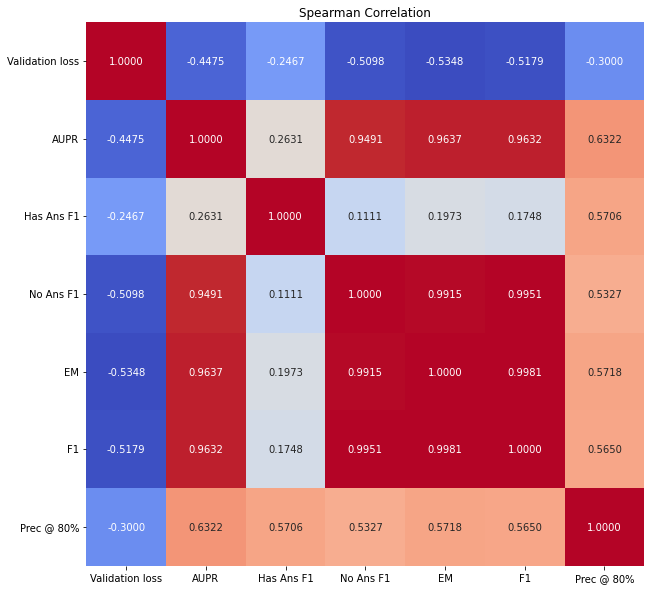

In [86]:
corr = df_hist.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_title('Spearman Correlation')
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('Figures_For_Report/SpearmanCorrObjectiveFunction.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

## Plot the val loss, train loss, and aupr as a function of steps

In [87]:
# set global step to index
df_hist_raw.set_index('trainer/global_step', inplace=True)

In [88]:
df_p = df_hist_raw[['epoch_valid_loss','performance_AUPR_valid_aupr','performance_stats_valid_HasAns_f1','performance_stats_valid_NoAns_f1','performance_stats_valid_exact','performance_stats_valid_f1', 'performance_AUPR_valid_prec_at_80_recall']]
df_p2 = df_p.rename(columns={'epoch_valid_loss':'Validation loss', 'performance_AUPR_valid_aupr':'AUPR', 'performance_stats_valid_HasAns_f1':'Has Ans F1', 'performance_stats_valid_NoAns_f1': 'No Ans F1', 'performance_stats_valid_exact':'EM', 'performance_stats_valid_f1':'F1', 'performance_AUPR_valid_prec_at_80_recall': 'Prec @ 80%'})
df_p2['AUPR']=df_p2['AUPR']*100
df_p2['Prec @ 80%']=df_p2['Prec @ 80%']*100

In [89]:
plt.figure(figsize=(8, 6), dpi=80)
df_p2.plot(    kind='scatter',
    x='Validation loss', 
    y=df_p2.columns, 
    backend='plotly', 
    width=500)

<Figure size 640x480 with 0 Axes>